## Introduction

In this notebook, I evaluate baseline machine learning models for predicting the mechanism of action (MoA) of compounds using the prepared multimodal dataset. The goal is to establish a performance benchmark using standard classifiers before exploring more advanced modeling techniques.

The notebook includes:
- Training and evaluation of multiple models (e.g. LGBM, CatBoost, MLP)
- Support for class imbalance handling via weighted loss functions
- Calculation of standard metrics such as accuracy, macro F1-score, and classification reports
- Analysis of per-class performance, with a focus on handling rare MoA categories

These results will serve as a reference point for future experiments involving model tuning, multimodal fusion, and deep learning architectures.

In [1]:
import os
import glob
from datetime import date

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# paths to data
save_path = "result/"

In [3]:
# loading our final dataset
file_merged_type = '/*[0-9]_' + 'merged.csv'
files_merged = glob.glob(save_path + file_merged_type)

# gets latest file
max_file_merged = max(files_merged, key=os.path.getctime)

# load file
df_merged = pd.read_csv(max_file_merged)
df_merged

,Metadata_EOS,Metadata_pdid,Metadata_name,Metadata_smiles,Metadata_inchi,Metadata_inchikey,Metadata_no. targets,Metadata_cas,Metadata_synonyms,binary_probe,...,fp_246,fp_247,fp_248,fp_249,fp_250,fp_251,fp_252,fp_253,fp_254,fp_255
0,EOS100001,PD003310,vincristine,CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@]...,InChI=1S/C46H56N4O10/c1-7-42(55)22-28-23-45(40...,OGWKCGZFUXNPDA-CFWMRBGOSA-N,4,132142-73-5;57-22-7,Leurocristine;NSC-67574;22-Oxovincaleukoblasti...,0,...,0,1,0,1,0,1,0,0,0,0
1,EOS100002,PD002995,finasteride,CC(C)(C)NC(=O)[C@H]1CC[C@H]2[C@@H]3CC[C@H]4NC(...,"InChI=1S/C23H36N2O2/c1-21(2,3)25-20(27)17-8-7-...",DBEPLOCGEIEOCV-WSBQPABSSA-N,18,98319-26-7;140375-21-9,CHEMBL710;MK-906;finasteride;Proscar;FINASTERI...,1,...,0,0,0,0,1,1,0,1,0,0
2,EOS100003,PD012798,Dubermatinib,CN1CCN(Cc2ccc(Nc3ncc(Cl)c(Nc4ccccc4S(=O)(=O)N(...,"InChI=1S/C24H30ClN7O2S/c1-30(2)35(33,34)22-7-5...",YUAALFPUEOYPNX-UHFFFAOYSA-N,3,1341200-45-0,TP0903;TP-0903;Dubermatinib(TP-0903);Dubermati...,0,...,0,0,0,0,0,1,0,0,0,1
3,EOS100005,PD002999,ezetimibe,O=C1[C@H](CC[C@H](O)c2ccc(F)cc2)[C@@H](c2ccc(O...,InChI=1S/C24H21F2NO3/c25-17-5-1-15(2-6-17)22(2...,OLNTVTPDXPETLC-XPWALMASSA-N,18,163222-33-1,ezetimibe;SCH 58235;Vytorin-ezetimibe;Ezetimib...,0,...,0,0,0,0,0,1,0,0,0,1
4,EOS100009,PD051680,Netazepide,CNc1cccc(NC(=O)N[C@@H]2N=C(c3ccccn3)c3ccccc3N(...,"InChI=1S/C28H30N6O3/c1-28(2,3)23(35)17-34-22-1...",YDZYKNJZCVIKPP-VWLOTQADSA-N,2,155488-25-8,YM-220;Netazepide;YF 476;YF-476;Sograzepide,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,EOS102437,PD095835,DIPHYLLIN,COc1cc2c(O)c3c(c(-c4ccc5c(c4)OCO5)c2cc1OC)C(=O...,InChI=1S/C21H16O7/c1-24-15-6-11-12(7-16(15)25-...,VMEJANRODATDOF-UHFFFAOYSA-N,11,22055-22-7,DIPHYLLIN,0,...,1,0,0,1,0,0,0,0,0,0
1112,EOS102438,PD085956,PD085956,Cc1[nH]c2ccccc2c1CN1CCN(c2ccccn2)CC1,InChI=1S/C19H22N4/c1-15-17(16-6-2-3-7-18(16)21...,ZAXKSLQZANTESC-UHFFFAOYSA-N,6,NaN,NaN,0,...,0,1,0,0,0,0,0,0,0,1
1113,EOS102439,PD086412,ESI-05,Cc1ccc(S(=O)(=O)c2c(C)cc(C)cc2C)cc1,"InChI=1S/C16H18O2S/c1-11-5-7-15(8-6-11)19(17,1...",CGPHOZWFSFNOEQ-UHFFFAOYSA-N,1,5184-64-5,NSC 116966;ESI-05;ESI 05,0,...,0,0,0,0,1,0,0,1,0,0
1114,EOS102449,PD009614,APRACLONIDINE,Nc1cc(Cl)c(NC2=NCCN2)c(Cl)c1,InChI=1S/C9H10Cl2N4/c10-6-3-5(12)4-7(11)8(6)15...,IEJXVRYNEISIKR-UHFFFAOYSA-N,12,66711-21-5,APRACLONIDINE;Pharmaprojects No. 1758,0,...,0,0,0,0,0,0,0,0,0,0


We need to determine columns to use it later:

In [4]:
metadata_cols = [col for col in df_merged.columns if col.startswith('Metadata_')]
binary_cols = [col for col in df_merged.columns if col.startswith('binary_')]
chemical_cols = [col for col in df_merged.columns if col.startswith('chemical_')]
moa_cols = [col for col in df_merged.columns if col.startswith('moa_')]
drug_status_cols = [col for col in df_merged.columns if col.startswith('drug_status_')]
fingerprints_cols = [col for col in df_merged.columns if col.startswith('fp_')]
morphology_cols = [col for col in df_merged.columns if col.startswith('morphology_')]

We have too many classes with small amount of date. We must select most popular classes:

In [ ]:
moa_counts = df_merged[moa_cols].sum().sort_values(ascending=False)
top_moa = moa_counts[moa_counts > 100].index.tolist()
top_moa

['moa_inhibitor', 'moa_antagonist', 'moa_agonist']

We will use helper class for handling full process of fit, evaluation and ploting result data:

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler

class MultimodalMoAPipeline:
    """
    A pipeline for multimodal classification tasks using morphological, chemical,
    and fingerprint features.

    Parameters
    ----------
    morph_cols : list of str, default=[]
        List of column names representing morphological features.

    chem_cols : list of str, default=[]
        List of column names representing chemical descriptors.

    fp_cols : list of str, default=[]
        List of column names representing fingerprint features.

    use_morph : bool, default=True
        Whether to include morphological features in the model.

    use_chem : bool, default=True
        Whether to include chemical features in the model.

    use_fp : bool, default=True
        Whether to include fingerprint features in the model.

    scaler : str or None, default='standard'
        Type of scaler to apply to features. Options:
            - 'standard': StandardScaler from sklearn
            - None or any other value: no scaling will be applied

        Note: Some models like CatBoost do not require scaling.

    model : sklearn-like classifier, default=None
        A scikit-learn compatible classifier. If None, defaults to
        RandomForestClassifier with predefined parameters.

    random_state : int, default=42
        Random seed for reproducibility.

    use_gridsearch : bool, default=False
        Whether to perform GridSearchCV to tune hyperparameters.
        Only supported for sklearn-compatible estimators.
    """
    def __init__(self, morph_cols=[], chem_cols=[], fp_cols=[],
                 use_morph=True, use_chem=True, use_fp=True,
                 scaler='standard', model=None, random_state=42,
                 use_gridsearch=False):
        self.morph_cols = morph_cols
        self.chem_cols = chem_cols
        self.fp_cols = fp_cols
        self.use_morph = use_morph
        self.use_chem = use_chem
        self.use_fp = use_fp
        
        self.scaler_type = scaler
        self.random_state = random_state
        self.use_gridsearch = use_gridsearch
        
        self.model = model if model is not None else RandomForestClassifier(n_estimators=200, random_state=random_state, class_weight='balanced', min_samples_leaf=3)

    def _get_feature_set(self, df):
        cols = []
        if self.use_morph:
            cols += self.morph_cols
        if self.use_chem:
            cols += self.chem_cols
        if self.use_fp:
            cols += self.fp_cols
        return df[cols].copy()

    def _scale(self, X):
        if self.scaler_type == 'standard':
            self.scaler = StandardScaler()
            X_scaled = pd.DataFrame(self.scaler.fit_transform(X), columns=X.columns, index=X.index)
            return X_scaled
        return X  # no scaling

    def fit(self, df, target_col):
        X = self._get_feature_set(df)
        X = self._scale(X)

        # Support for multilabel: if target_col — it's a one-hot list
        if isinstance(target_col, list):
            df = df.copy()
            df['__moa_label'] = df[target_col].idxmax(axis=1)
            y = df['__moa_label']
        else:
            y = df[target_col]

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, stratify=y, test_size=0.2, random_state=self.random_state
        )

        if self.use_gridsearch:
            param_grid = {
                'n_estimators': [100, 200],
                'max_depth': [None, 10, 20],
                'min_samples_leaf': [1, 3, 5],
                'class_weight': ['balanced']
            }
            base_model = RandomForestClassifier(random_state=self.random_state)
            cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=self.random_state)
            grid = GridSearchCV(base_model, param_grid, scoring='f1_macro', cv=cv_strategy, n_jobs=-1)
            grid.fit(self.X_train, self.y_train)
            print("Best params from GridSearchCV:", grid.best_params_)
            self.model = grid.best_estimator_
        else:
            self.model.fit(self.X_train, self.y_train)

        self.y_pred = self.model.predict(self.X_test)


    def evaluate(self):
        acc = accuracy_score(self.y_test, self.y_pred)
        f1 = f1_score(self.y_test, self.y_pred, average='macro')

        print(f"\n🎯 Accuracy: {acc:.4f}")
        print(f"🎯 Macro F1-score: {f1:.4f}\n")
        print("Classification Report:\n")
        print(classification_report(self.y_test, self.y_pred))

        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(self.y_test, self.y_pred, labels=self.model.classes_)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.model.classes_, yticklabels=self.model.classes_)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()
        
        # PR and ROC curves only for binary classification
        if len(self.model.classes_) == 2:
            y_proba = self.model.predict_proba(self.X_test)[:, 1]

            # Precision-Recall Curve
            precision, recall, thresholds = precision_recall_curve(self.y_test, y_proba)
            avg_precision = average_precision_score(self.y_test, y_proba)

            plt.figure(figsize=(8, 6))
            plt.plot(recall, precision, marker='.')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title(f'Precision-Recall Curve (AP = {avg_precision:.4f})')
            plt.grid()
            plt.tight_layout()
            plt.show()

            # ROC Curve
            fpr, tpr, _ = roc_curve(self.y_test, y_proba)
            roc_auc = roc_auc_score(self.y_test, y_proba)

            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
            plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve')
            plt.legend(loc='lower right')
            plt.grid()
            plt.tight_layout()
            plt.show()

    def plot_importance(self, top_n=30):
        if not hasattr(self.model, 'feature_importances_'):
            print("This model does not support feature importances.")
            return

        feat_imp = pd.DataFrame({
            'feature': self.X_train.columns,
            'importance': self.model.feature_importances_
        })

        # Figure out the feature groups
        def get_group(feature):
            if feature in self.morph_cols:
                return 'morphology'
            elif feature in self.chem_cols:
                return 'chemistry'
            elif feature in self.fp_cols:
                return 'fingerprint'
            else:
                return 'other'

        feat_imp['group'] = feat_imp['feature'].apply(get_group)

        # Group by feature group and sum importances
        grouped = feat_imp.groupby('group')['importance'].sum().sort_values(ascending=False)
        print("\n📊 Feature Importance by Group:")
        print(grouped)

        # Sort and select top_n features
        feat_imp = feat_imp.sort_values(by='importance', ascending=False).head(top_n)

        plt.figure(figsize=(12, 8))
        sns.barplot(data=feat_imp, x='importance', y='feature', hue='group', dodge=False, palette='viridis')
        plt.title(f"Top {top_n} Feature Importances by Group")
        plt.tight_layout()
        plt.show()

        return feat_imp
    

First, let's try to use LGBMClassifier model:

In [8]:
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    class_weight='balanced',
    random_state=42,
    verbosity=-1
)

And then create pipeline object:

In [41]:
lgbm_pipe = MultimodalMoAPipeline(
    morph_cols=morphology_cols,
    chem_cols=chemical_cols,
    fp_cols=fingerprints_cols,
    use_gridsearch=True,
    model=lgbm_model
)

And now fit and evaluate model:

Best params from GridSearchCV: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 200}

🎯 Accuracy: 0.8839
🎯 Macro F1-score: 0.3128

Classification Report:

                precision    recall  f1-score   support

   moa_agonist       0.00      0.00      0.00        14
moa_antagonist       0.00      0.00      0.00        12
 moa_inhibitor       0.88      1.00      0.94       198

      accuracy                           0.88       224
     macro avg       0.29      0.33      0.31       224
  weighted avg       0.78      0.88      0.83       224



/opt/miniconda3/envs/vspaint/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/vspaint/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/vspaint/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


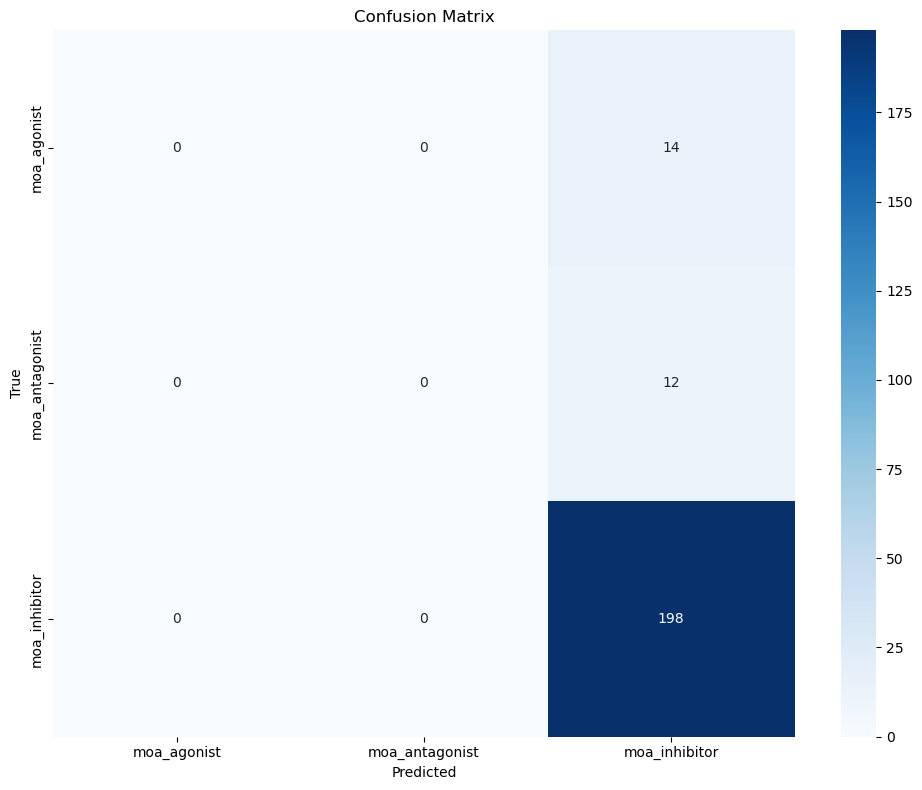


📊 Feature Importance by Group:
group
morphology     0.847758
fingerprint    0.085781
chemistry      0.066461
Name: importance, dtype: float64


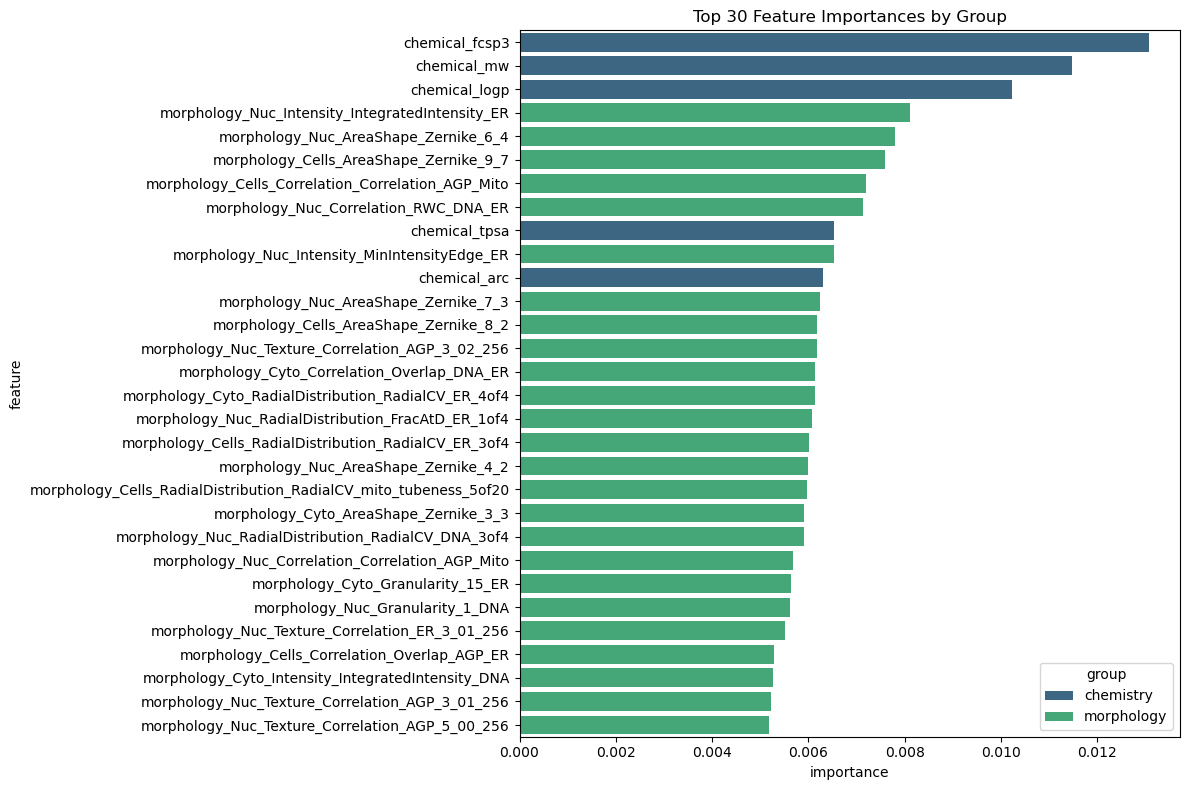

,feature,importance,group
249,chemical_fcsp3,0.013061,chemistry
241,chemical_mw,0.011465,chemistry
247,chemical_logp,0.010229,chemistry
92,morphology_Nuc_Intensity_IntegratedIntensity_ER,0.008104,morphology
25,morphology_Nuc_AreaShape_Zernike_6_4,0.007788,morphology
11,morphology_Cells_AreaShape_Zernike_9_7,0.007595,morphology
201,morphology_Cells_Correlation_Correlation_AGP_Mito,0.007202,morphology
225,morphology_Nuc_Correlation_RWC_DNA_ER,0.007129,morphology
248,chemical_tpsa,0.006528,chemistry
132,morphology_Nuc_Intensity_MinIntensityEdge_ER,0.006524,morphology


In [42]:
lgbm_pipe.fit(df_merged, target_col=top_moa)
lgbm_pipe.evaluate()
lgbm_pipe.plot_importance()

Results are not great, model completely ignores moa_agonist and moa_antagonist classes because of small data amount.

Let's try GradientBoostingClassifier:

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

gboost_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

In [17]:
gboost_pipe = MultimodalMoAPipeline(
    morph_cols=morphology_cols,
    chem_cols=chemical_cols,
    fp_cols=fingerprints_cols,
    use_gridsearch=False,
    model=gboost_model
)


🎯 Accuracy: 0.8661
🎯 Macro F1-score: 0.3463

Classification Report:

                precision    recall  f1-score   support

   moa_agonist       0.25      0.07      0.11        14
moa_antagonist       0.00      0.00      0.00        12
 moa_inhibitor       0.89      0.97      0.93       198

      accuracy                           0.87       224
     macro avg       0.38      0.35      0.35       224
  weighted avg       0.80      0.87      0.83       224



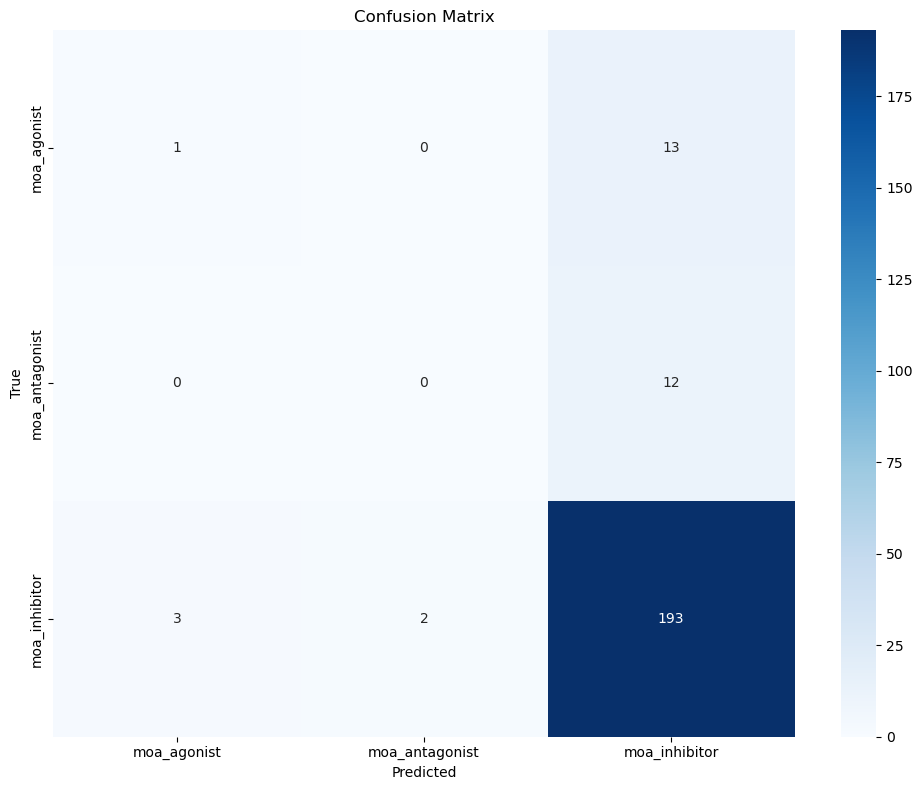


📊 Feature Importance by Group:
group
morphology     0.755992
fingerprint    0.133564
chemistry      0.110443
Name: importance, dtype: float64


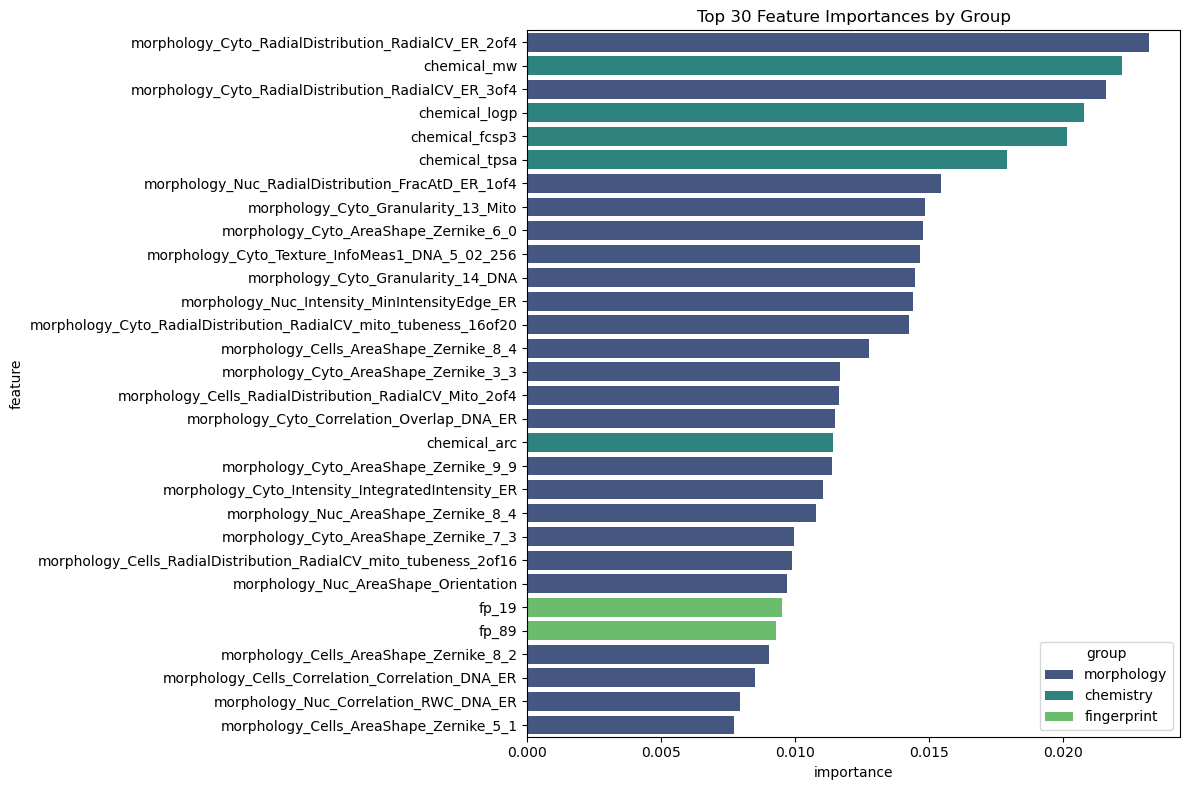

,feature,importance,group
111,morphology_Cyto_RadialDistribution_RadialCV_ER...,0.023220,morphology
241,chemical_mw,0.022201,chemistry
128,morphology_Cyto_RadialDistribution_RadialCV_ER...,0.021600,morphology
247,chemical_logp,0.020779,chemistry
249,chemical_fcsp3,0.020156,chemistry
248,chemical_tpsa,0.017935,chemistry
137,morphology_Nuc_RadialDistribution_FracAtD_ER_1of4,0.015459,morphology
73,morphology_Cyto_Granularity_13_Mito,0.014858,morphology
160,morphology_Cyto_AreaShape_Zernike_6_0,0.014769,morphology
180,morphology_Cyto_Texture_InfoMeas1_DNA_5_02_256,0.014661,morphology


In [16]:
gboost_pipe.fit(df_merged, target_col=top_moa)
gboost_pipe.evaluate()
gboost_pipe.plot_importance()

Model shows slightly better results and finally can predict somehow moa_agonist class.

Let's try to predict only one moa class (with lgbm and gboost classifiers):

Best params from GridSearchCV: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 200}

🎯 Accuracy: 0.6429
🎯 Macro F1-score: 0.6400

Classification Report:

              precision    recall  f1-score   support

           0       0.61      0.60      0.61       103
           1       0.67      0.68      0.67       121

    accuracy                           0.64       224
   macro avg       0.64      0.64      0.64       224
weighted avg       0.64      0.64      0.64       224



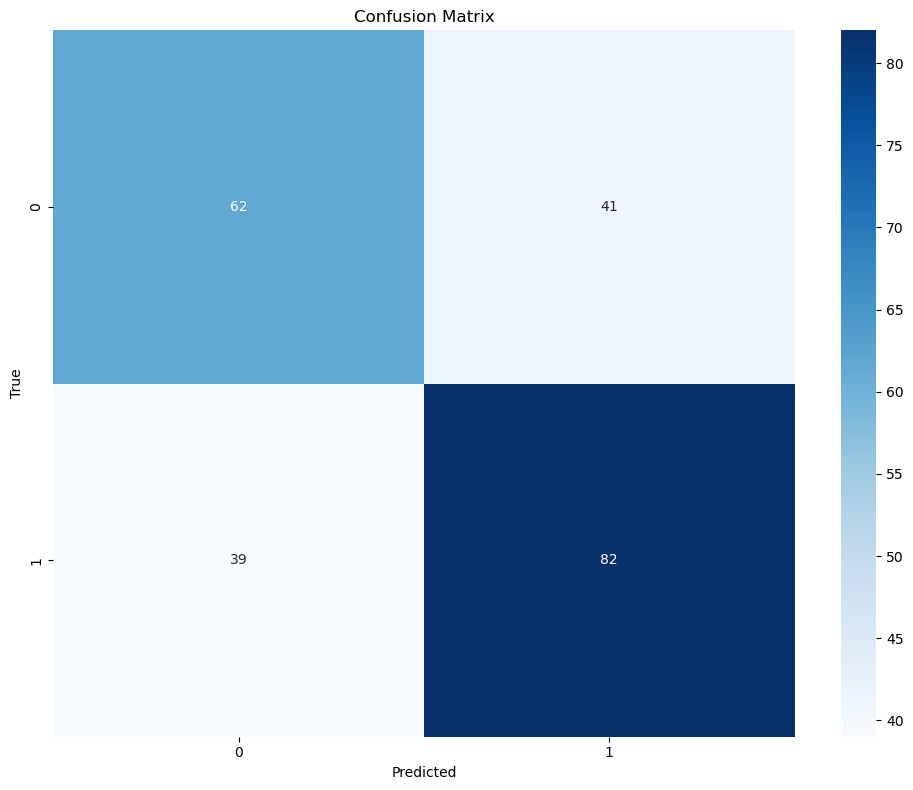

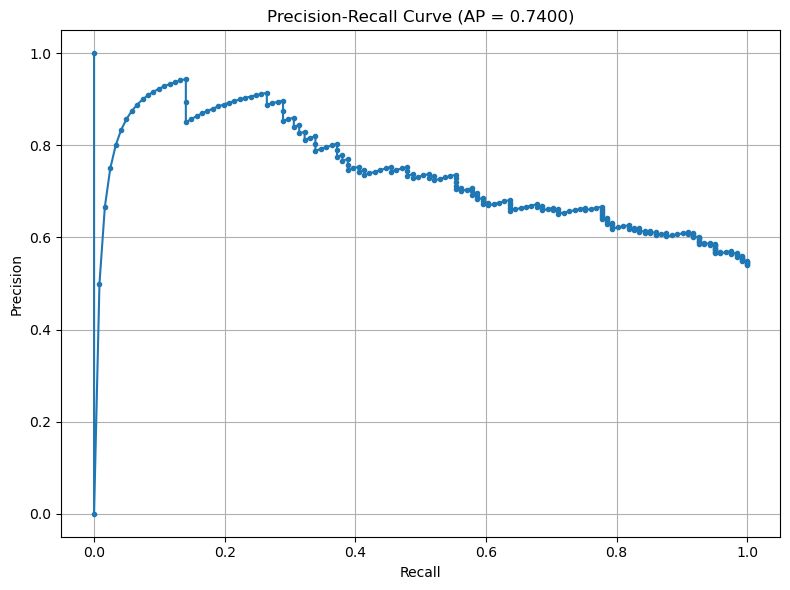

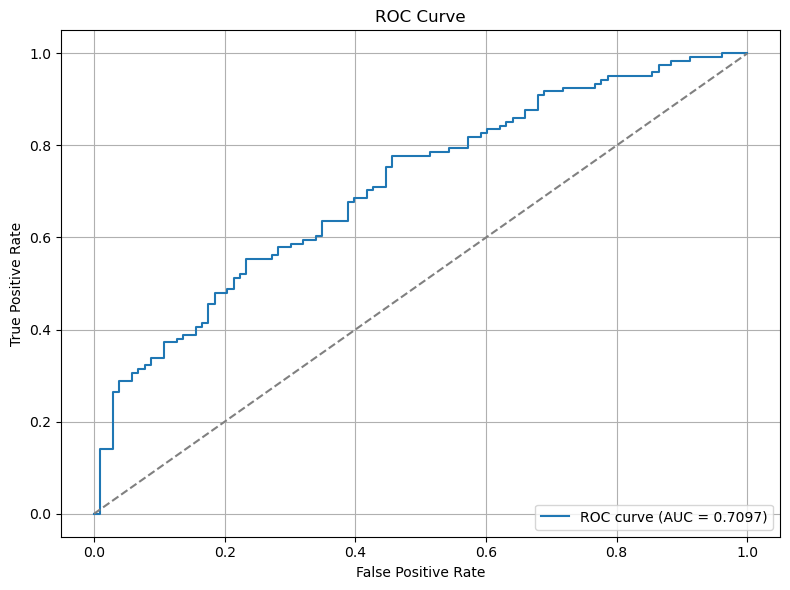


📊 Feature Importance by Group:
group
morphology     0.857274
fingerprint    0.084855
chemistry      0.057871
Name: importance, dtype: float64


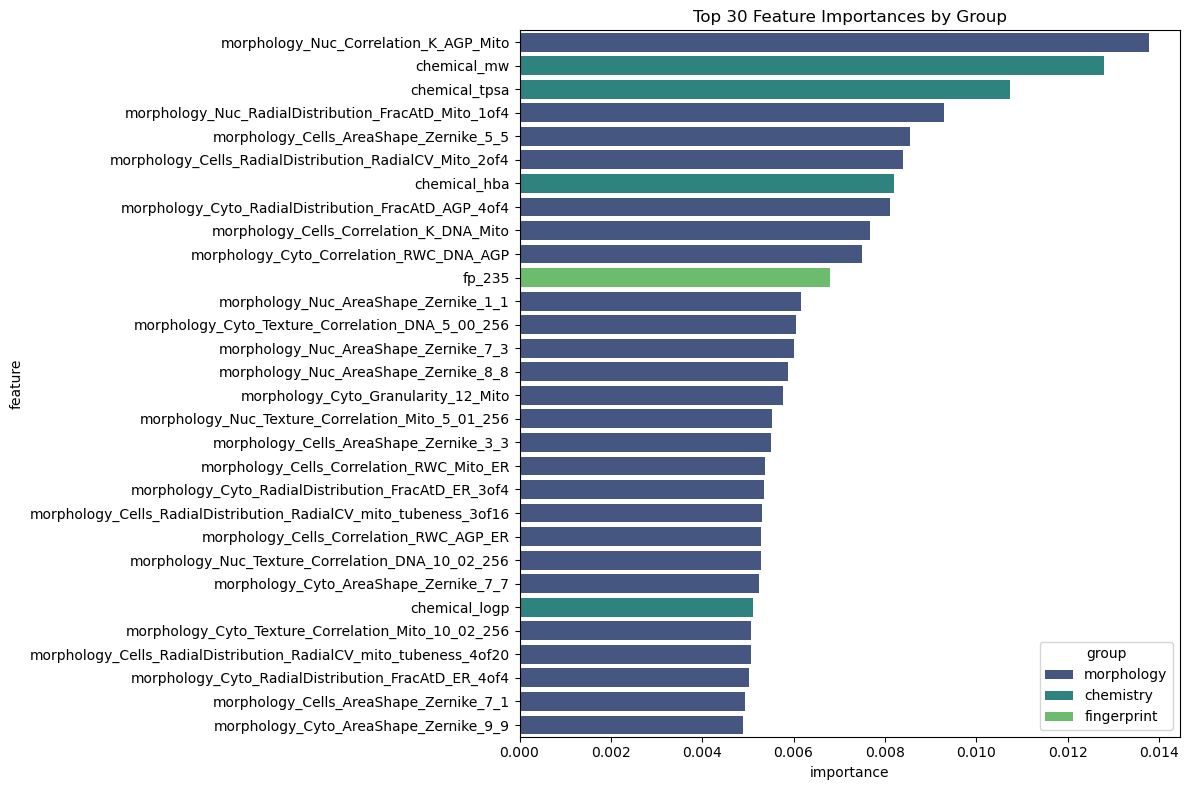

,feature,importance,group
209,morphology_Nuc_Correlation_K_AGP_Mito,0.013773,morphology
241,chemical_mw,0.012802,chemistry
248,chemical_tpsa,0.010745,chemistry
64,morphology_Nuc_RadialDistribution_FracAtD_Mito...,0.009294,morphology
146,morphology_Cells_AreaShape_Zernike_5_5,0.008555,morphology
63,morphology_Cells_RadialDistribution_RadialCV_M...,0.008391,morphology
242,chemical_hba,0.008208,chemistry
233,morphology_Cyto_RadialDistribution_FracAtD_AGP...,0.008103,morphology
214,morphology_Cells_Correlation_K_DNA_Mito,0.007667,morphology
158,morphology_Cyto_Correlation_RWC_DNA_AGP,0.007510,morphology


In [18]:
lgbm_pipe.fit(df_merged, target_col='moa_inhibitor')
lgbm_pipe.evaluate()
lgbm_pipe.plot_importance()


🎯 Accuracy: 0.6473
🎯 Macro F1-score: 0.6448

Classification Report:

              precision    recall  f1-score   support

           0       0.62      0.61      0.61       103
           1       0.67      0.68      0.67       121

    accuracy                           0.65       224
   macro avg       0.64      0.64      0.64       224
weighted avg       0.65      0.65      0.65       224



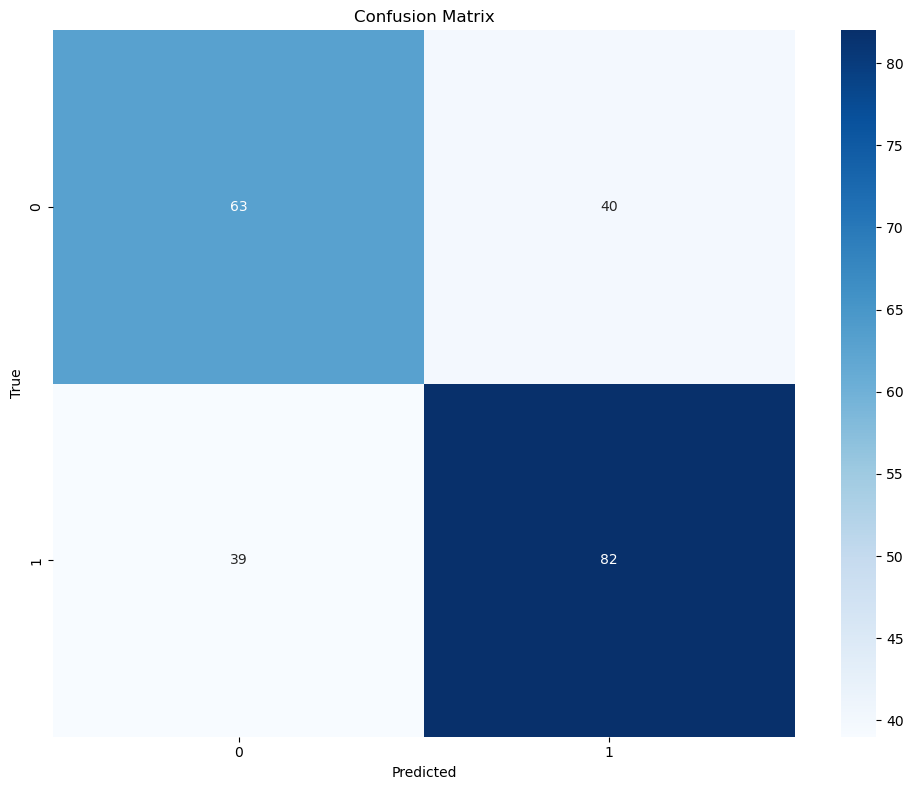

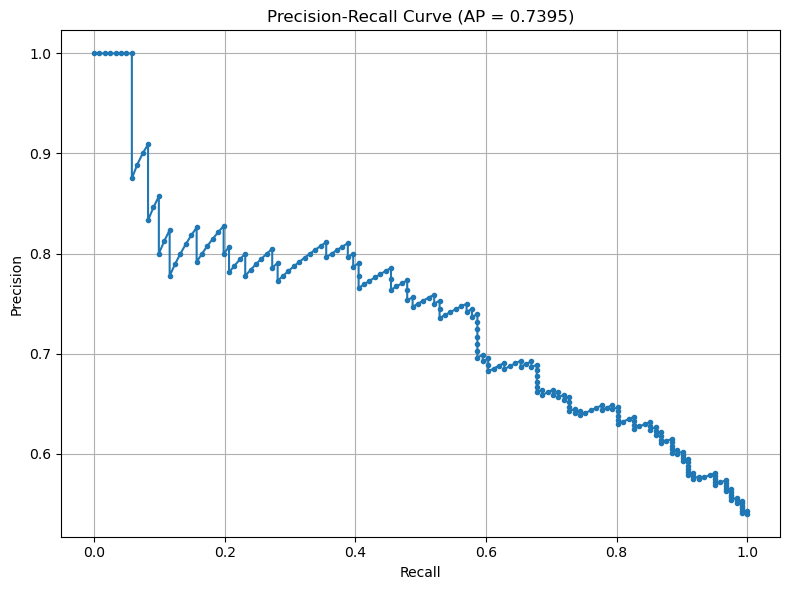

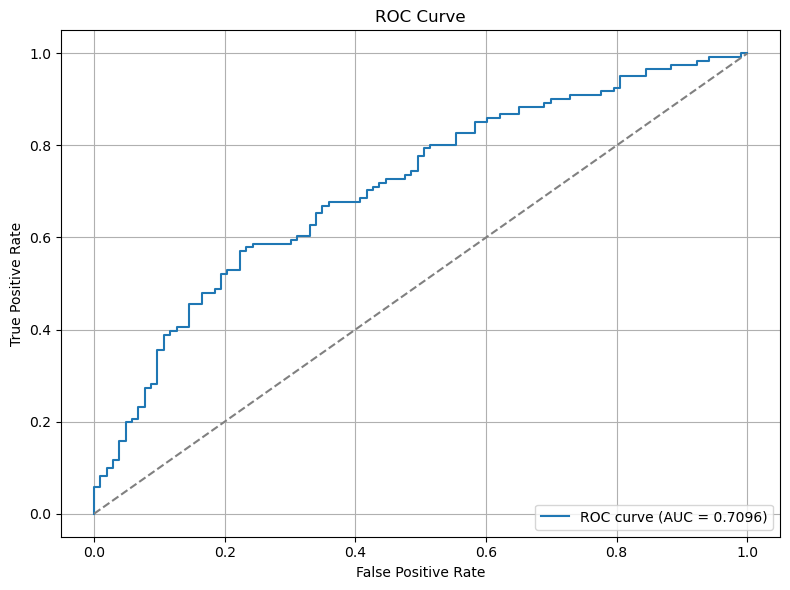


📊 Feature Importance by Group:
group
morphology     0.788404
chemistry      0.112588
fingerprint    0.099007
Name: importance, dtype: float64


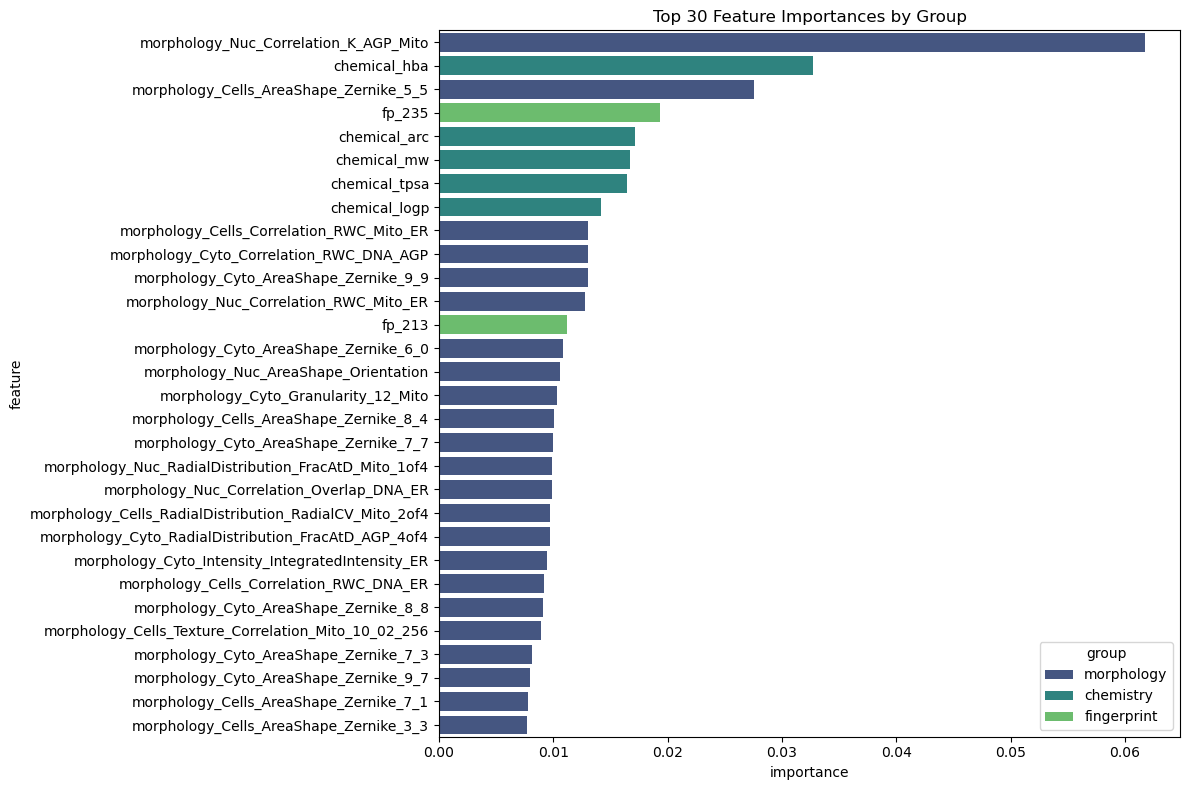

,feature,importance,group
209,morphology_Nuc_Correlation_K_AGP_Mito,0.061739,morphology
242,chemical_hba,0.032747,chemistry
146,morphology_Cells_AreaShape_Zernike_5_5,0.027565,morphology
488,fp_235,0.019324,fingerprint
246,chemical_arc,0.017176,chemistry
241,chemical_mw,0.016672,chemistry
248,chemical_tpsa,0.016458,chemistry
247,chemical_logp,0.014197,chemistry
7,morphology_Cells_Correlation_RWC_Mito_ER,0.013071,morphology
158,morphology_Cyto_Correlation_RWC_DNA_AGP,0.013064,morphology


In [19]:
gboost_pipe.fit(df_merged, target_col='moa_inhibitor')
gboost_pipe.evaluate()
gboost_pipe.plot_importance()

The models works much better with a single class. GBoost is slightly better than LGBM but still far away from perfect prediction.

Let's try CatBoostClassifier with computed class weight for multy target task:

In [22]:
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight

X = df_merged[morphology_cols + chemical_cols + fingerprints_cols]
y = df_merged[top_moa].idxmax(axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

classes = y_train.unique()
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

cat_boost_model = CatBoostClassifier(
    iterations=300,
    depth=6,
    learning_rate=0.1,
    loss_function='MultiClass',
    class_weights=class_weights,
    eval_metric='TotalF1',
    random_seed=42,
    verbose=50,
)

In [ ]:
cat_boost_pipe = MultimodalMoAPipeline(
    morph_cols=morphology_cols,
    chem_cols=chemical_cols,
    fp_cols=fingerprints_cols,
    use_gridsearch=False,
    model=cat_boost_model
)

0:	learn: 0.5322566	total: 167ms	remaining: 50.1s
50:	learn: 0.9699880	total: 2.13s	remaining: 10.4s
100:	learn: 0.9944769	total: 4.13s	remaining: 8.14s
150:	learn: 0.9991516	total: 6.23s	remaining: 6.14s
200:	learn: 1.0000000	total: 8.37s	remaining: 4.12s
250:	learn: 1.0000000	total: 10.6s	remaining: 2.06s
299:	learn: 1.0000000	total: 12.7s	remaining: 0us

🎯 Accuracy: 0.8795
🎯 Macro F1-score: 0.3986

Classification Report:

                precision    recall  f1-score   support

   moa_agonist       0.33      0.07      0.12        14
moa_antagonist       0.50      0.08      0.14        12
 moa_inhibitor       0.89      0.98      0.94       198

      accuracy                           0.88       224
     macro avg       0.57      0.38      0.40       224
  weighted avg       0.83      0.88      0.84       224



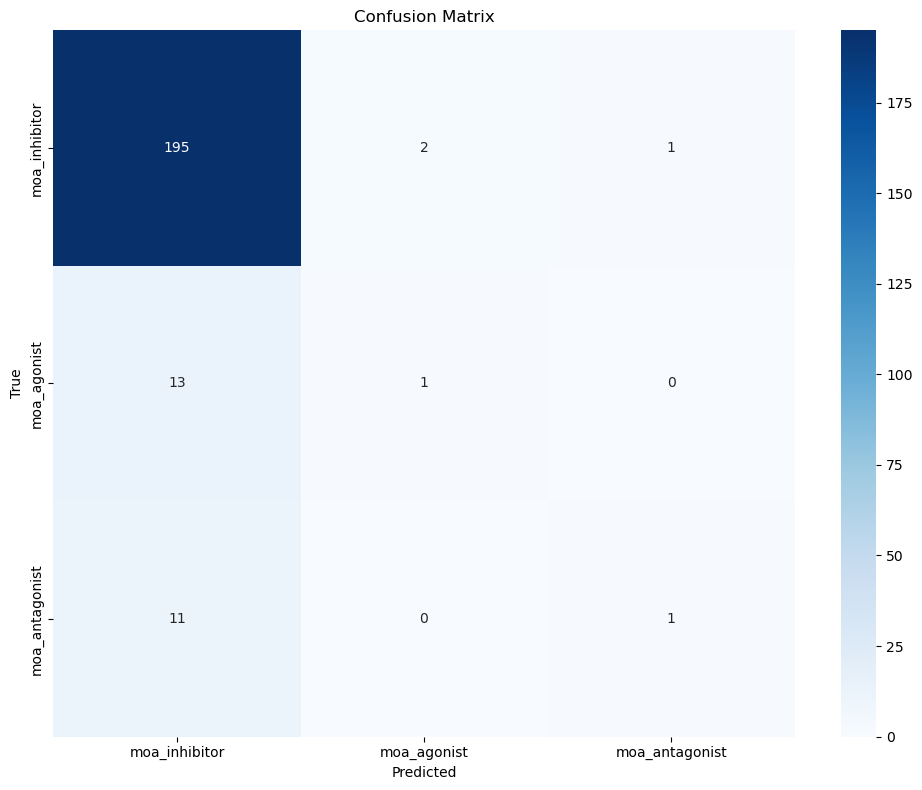


📊 Feature Importance by Group:
group
fingerprint    51.655651
morphology     44.655384
chemistry       3.688964
Name: importance, dtype: float64


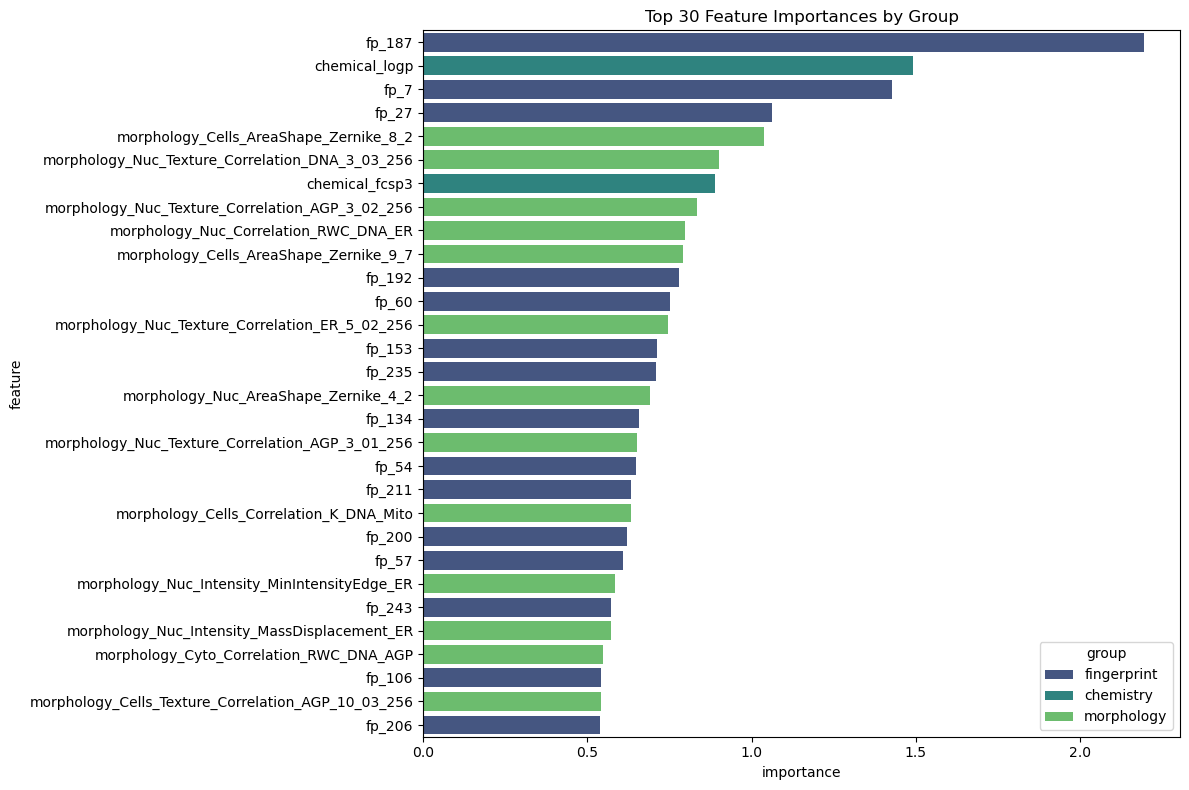

,feature,importance,group
440,fp_187,2.195549,fingerprint
247,chemical_logp,1.493120,chemistry
260,fp_7,1.427070,fingerprint
280,fp_27,1.063237,fingerprint
172,morphology_Cells_AreaShape_Zernike_8_2,1.036597,morphology
143,morphology_Nuc_Texture_Correlation_DNA_3_03_256,0.899774,morphology
249,chemical_fcsp3,0.888904,chemistry
231,morphology_Nuc_Texture_Correlation_AGP_3_02_256,0.832438,morphology
225,morphology_Nuc_Correlation_RWC_DNA_ER,0.796199,morphology
11,morphology_Cells_AreaShape_Zernike_9_7,0.791500,morphology


In [24]:
cat_boost_pipe.fit(df_merged, target_col=top_moa)
cat_boost_pipe.evaluate()
cat_boost_pipe.plot_importance()

CatBoostClassifier with computed class weight works slightly better than previous models. Computing class weight helps to balance classes distribution.

Let's try to develop custom neural network with torch.

The model is a simple Multi-Layer Perceptron (MLP) for a multi-label classification task. It consists of:
- Input layer → Linear (input_dim → 512)
- Hidden layer 1 → ReLU + Dropout(0.3)
- Hidden layer 2 → Linear (512 → 256) + ReLU + Dropout(0.2)
-	Output layer → Linear (256 → output_dim), no activation (because we use BCEWithLogitsLoss which applies sigmoid internally)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

X = df_merged[morphology_cols + chemical_cols + fingerprints_cols]
y = df_merged[top_moa]

# split the data
X_train, X_val, y_train, y_val = train_test_split(
    X.values, y.values, test_size=0.2, random_state=42
)

# convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# simple MLP model
class MoAModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.net(x)  # logits

# model
model = MoAModel(input_dim=X.shape[1], output_dim=y.shape[1]).to(device)

# class weights
pos_counts = y_train_tensor.sum(dim=0)
neg_counts = y_train_tensor.shape[0] - pos_counts
pos_weight = (neg_counts / pos_counts) ** 0.5
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 100
best_f1 = 0.0
patience = 5 
counter = 0
best_model_state = None

train_losses = []
val_f1s = []

# training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_tensor)
        val_probs = torch.sigmoid(val_preds).cpu().numpy()
        val_preds_bin = (val_probs > 0.5).astype(int)
        y_true = y_val_tensor.cpu().numpy()

        f1_macro = f1_score(y_true, val_preds_bin, average='macro')
        val_f1s.append(f1_macro)

    print(f"Epoch {epoch+1}: train_loss={avg_loss:.4f}  val_f1_macro={f1_macro:.4f}")
    
    if f1_macro > best_f1 + 1e-4:
        best_f1 = f1_macro
        best_model_state = model.state_dict()
        counter = 0
        print("  F1 is better — save the model")
    else:
        counter += 1
        print(f"  No changes {counter}/{patience}")
        if counter >= patience:
            print("Stop: no improvements in F1")
            break
        
if best_model_state:
    model.load_state_dict(best_model_state)

Epoch 1: train_loss=1.0679  val_f1_macro=0.2256
  F1 is better — save the model
Epoch 2: train_loss=0.7298  val_f1_macro=0.2425
  F1 is better — save the model
Epoch 3: train_loss=0.6387  val_f1_macro=0.2373
  No changes 1/5
Epoch 4: train_loss=0.6167  val_f1_macro=0.3180
  F1 is better — save the model
Epoch 5: train_loss=0.5967  val_f1_macro=0.3683
  F1 is better — save the model
Epoch 6: train_loss=0.5983  val_f1_macro=0.4150
  F1 is better — save the model
Epoch 7: train_loss=0.5821  val_f1_macro=0.3752
  No changes 1/5
Epoch 8: train_loss=0.5696  val_f1_macro=0.3651
  No changes 2/5
Epoch 9: train_loss=0.5511  val_f1_macro=0.3543
  No changes 3/5
Epoch 10: train_loss=0.5235  val_f1_macro=0.4101
  No changes 4/5
Epoch 11: train_loss=0.5121  val_f1_macro=0.4509
  F1 is better — save the model
Epoch 12: train_loss=0.5181  val_f1_macro=0.3829
  No changes 1/5
Epoch 13: train_loss=0.4861  val_f1_macro=0.4079
  No changes 2/5
Epoch 14: train_loss=0.4723  val_f1_macro=0.4122
  No changes

Now let's eval our model:


🎯 Accuracy: 0.4688
🎯 Macro F1-score: 0.4226
🎯 Micro F1-score: 0.5359

Classification Report:
                precision    recall  f1-score   support

 moa_inhibitor       0.63      0.67      0.65       115
moa_antagonist       0.33      0.48      0.39        29
   moa_agonist       0.23      0.22      0.23        27

     micro avg       0.51      0.57      0.54       171
     macro avg       0.40      0.46      0.42       171
  weighted avg       0.51      0.57      0.54       171
   samples avg       0.40      0.40      0.39       171



/opt/miniconda3/envs/vspaint/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/vspaint/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


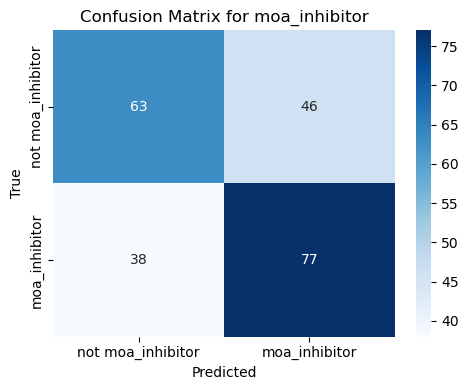

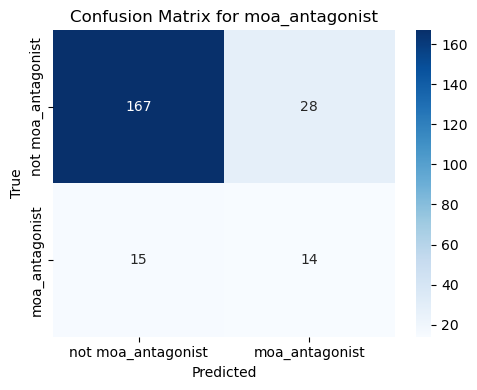

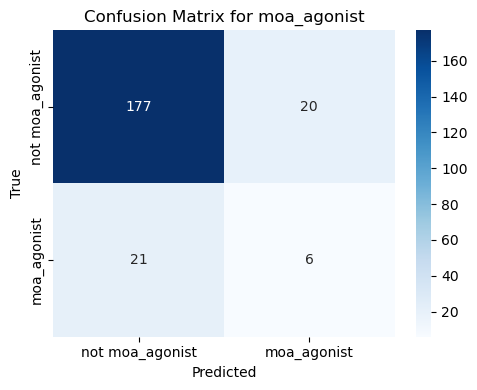

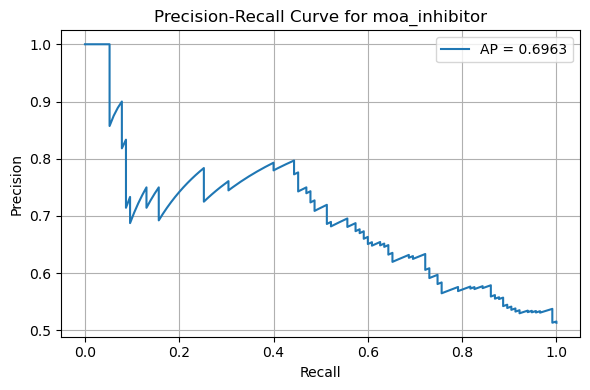

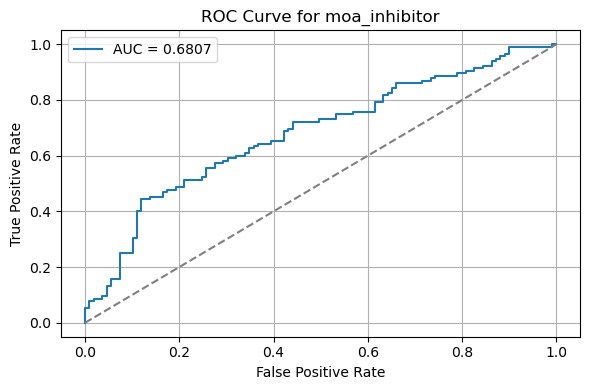

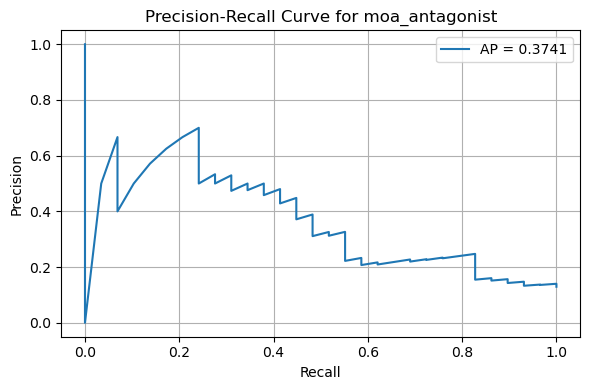

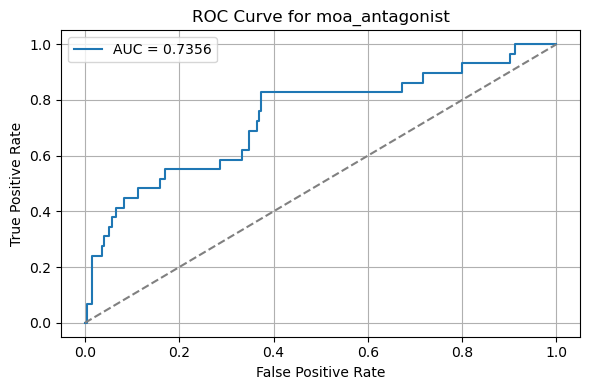

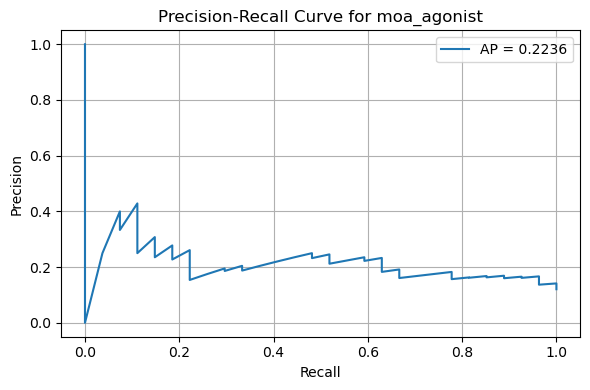

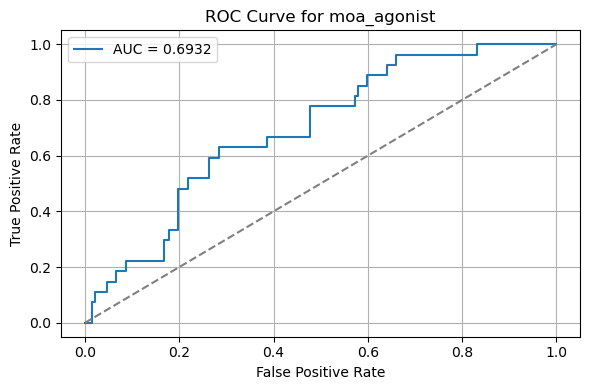

In [ ]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt

class_names = list(y.columns)

# Evaluate
model.eval()
with torch.no_grad():
    val_logits = model(X_val_tensor)
    val_probs = torch.sigmoid(val_logits).cpu().numpy()
    val_preds_bin = (val_probs > 0.5).astype(int)
    y_true = y_val_tensor.cpu().numpy()

# Macro/micro F1
f1_macro = f1_score(y_true, val_preds_bin, average='macro')
f1_micro = f1_score(y_true, val_preds_bin, average='micro')
acc = accuracy_score(y_true, val_preds_bin)

print(f"\n🎯 Accuracy: {acc:.4f}")
print(f"🎯 Macro F1-score: {f1_macro:.4f}")
print(f"🎯 Micro F1-score: {f1_micro:.4f}\n")

print("Classification Report:")
print(classification_report(y_true, val_preds_bin, target_names=class_names))

# Confusion matrix
for i, name in enumerate(class_names):
    cm = confusion_matrix(y_true[:, i], val_preds_bin[:, i])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f'not {name}', name],
                yticklabels=[f'not {name}', name])
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# PR и ROC кривые на каждый класс
for i, name in enumerate(class_names):
    probs = val_probs[:, i]
    true = y_true[:, i]

    precision, recall, _ = precision_recall_curve(true, probs)
    ap = average_precision_score(true, probs)

    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label=f'AP = {ap:.4f}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve for {name}")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    fpr, tpr, _ = roc_curve(true, probs)
    auc_score = roc_auc_score(true, probs)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {name}")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

## Model Evaluation Report

In this study, I evaluated several classification models for predicting mechanisms of action (MOAs) in a multi-class or multi-label context. The focus was to determine which model provides the best balance between accuracy and generalization across underrepresented classes. Below, I summarize the performance of each model tested and provide conclusions regarding their suitability as a baseline.

### Summary Table

| Model                          | Classes                                   | Accuracy | Macro F1 | Notes |
|-------------------------------|-------------------------------------------|----------|----------|-------|
| **LGBMClassifier**            | `'inhibitor', 'antagonist', 'agonist'`  | 0.8839   | 0.3128   | High accuracy on dominant class, fails on others |
| **GradientBoostingClassifier**| `'inhibitor', 'antagonist', 'agonist'`  | 0.8661   | 0.3463   | Slightly better F1 balance, still poor on small classes |
| **CatBoostClassifier + class weights** | `'inhibitor', 'antagonist', 'agonist'` | 0.8795 | 0.3986   | Best macro F1, recognizes all classes |
| **MLP (MultiLabel)**          | `'inhibitor', 'antagonist', 'agonist'`  | 0.4688   | 0.4226   | Strong multilabel capability, low overall precision |
| **LGBMClassifier**            | `'inhibitor'`                            | 0.6429   | 0.6400   | Binary classification only, limited use |
| **GradientBoostingClassifier**| `'inhibitor'`                            | 0.6473   | 0.6448   | Similar to LGBM, slightly better |

### Model-by-Model Analysis

#### LGBMClassifier (3 classes)
- This model achieved high overall accuracy by strongly favoring the `moa_inhibitor` class.
- However, it failed completely on the minority classes (`moa_antagonist`, `moa_agonist`), resulting in a poor macro F1-score.
- **Conclusion**: Not suitable for multi-class generalization. Performance is skewed.

#### GradientBoostingClassifier (3 classes)
- Similar to LGBM, but showed slight improvement in recall for minor classes.
- Still struggled with true generalization and exhibited class imbalance issues.
- **Conclusion**: A small improvement over LGBM, but still insufficient for robust performance across classes.

#### CatBoostClassifier + Class Weights
- Outperformed both LGBM and Gradient Boosting in terms of macro F1.
- Managed to make non-zero predictions for minority classes due to class balancing.
- High precision and recall for the dominant class were maintained.
- **Conclusion**: **Best overall model**. Balanced performance makes it a strong candidate for baseline use.

#### MLP (MultiLabel)
- The only model configured for multi-label output.
- Demonstrated reasonable class-wise participation, including for `agonist` and `antagonist`.
- However, accuracy and precision remain low.
- **Conclusion**: Promising for future multilabel work, but currently underperforms in predictive power.

#### LGBM & GradientBoosting (Single-class: `moa_inhibitor`)
- Performed well on their focused task.
- High macro F1 and balanced metrics for the `inhibitor` class only.
- **Conclusion**: Appropriate for isolated class-specific classification, not generalizable to full MOA space.

### Final Recommendation

The **CatBoostClassifier with balanced class weights** emerges as the most suitable baseline model for this task. It achieves a strong balance between class generalization and accuracy, especially when minor classes are important for the task.

### Future work will include:
- Improving multi-label architectures such as MLP.
- Exploring sampling techniques to mitigate class imbalance.
- Testing domain-specific feature importance and dimensionality reduction strategies.